In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential

import glob, os, random

Using TensorFlow backend.


In [2]:
base_path = 'dataset/training'

img_list = glob.glob(os.path.join(base_path, '*/*')) + glob.glob(os.path.join(base_path, '*/*/*'))

print(len(img_list))

4967


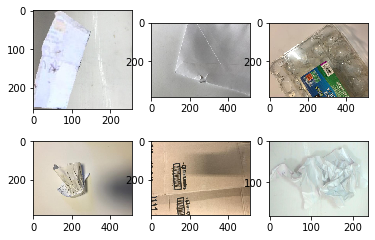

In [3]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    print(img)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [4]:
# train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

# train 데이터셋 불러오기
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)


# test
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)



# train 데이터셋 불러오기
validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 4456 images belonging to 6 classes.
Found 491 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [5]:
# Sequential() : layer를 선형으로 쌓음. 선형모델
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(6, activation='softmax')
])

# compile() : 학습 방법 선정/ 모델이 어느정도 형태를 갖추면 학습방법 선정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 32)       

In [6]:
# 모델 학습시키기
model.fit_generator(train_generator, epochs=3, validation_data=validation_generator)

Epoch 1/3
279/279 [==============================] - 806s 3s/step - loss: 1.4148 - acc: 0.3956 - val_loss: 0.9441 - val_acc: 0.4440
Epoch 2/3
279/279 [==============================] - 843s 3s/step - loss: 1.2258 - acc: 0.4818 - val_loss: 0.7701 - val_acc: 0.4460
Epoch 3/3
279/279 [==============================] - 784s 3s/step - loss: 1.1583 - acc: 0.5227 - val_loss: 1.2741 - val_acc: 0.4664


In [7]:
# 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator(validation_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
acc: 52.50%


In [8]:
# 모델 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

# 모델 weight 저장
keras_file="garbage.h5"
model.save(keras_file)

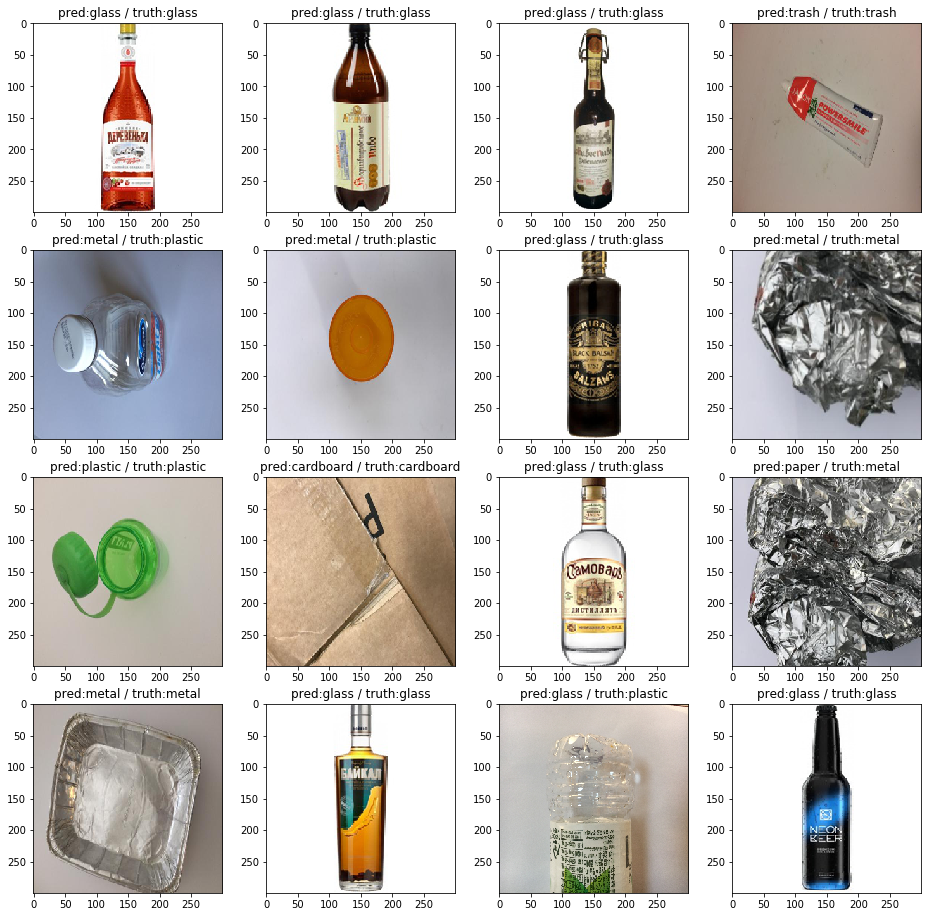

In [9]:
test_x, test_y = validation_generator.__getitem__(1)

# 모델 예측하기
# predict() : 예측
print("-- Predict --")
preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])